## DQN notebook

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html \
https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html \
https://huggingface.co/learn/deep-rl-course/unit4/introduction \
https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py \
https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb \

### PyTorch tutorial

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Experience replay memory for training DQN. It stores the transitions that the agent observes, allowing us to reuse this data later by sampling from it randomly.

Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

select_action - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.

plot_durations - a helper for plotting the duration of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [4]:
BATCH_SIZE = 128        # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99            # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9         # EPS_START is the starting value of epsilon
EPS_END = 0.05          # EPS_END is the final value of epsilon
EPS_DECAY = 1000        # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005             # TAU is the update rate of the target network
LR = 1e-4               # LR is the learning rate of the ``AdamW`` optimizer

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                    device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


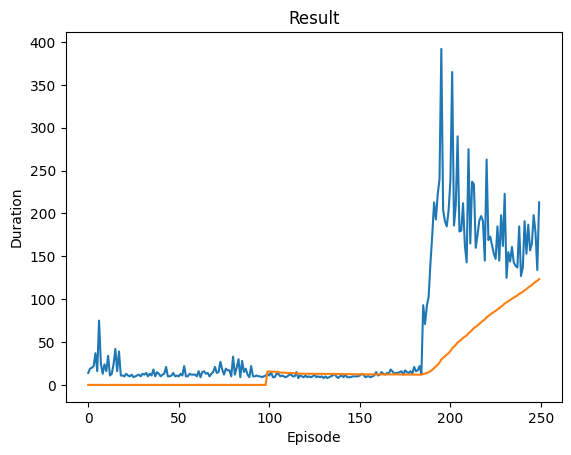

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

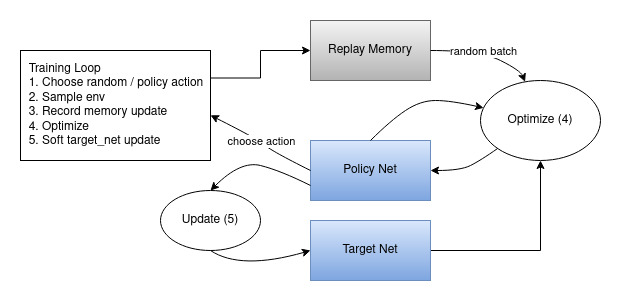

### Example from Huggingface RL cource

In [ ]:
# used old gym
# !pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt

In [1]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
# import gym_pygame

# Hugging Face Hub
# from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

In [2]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-1.8581249e+00 -2.9786856e+38  2.3174675e-01 -1.9517179e+38]


In [4]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [5]:
state = env.reset()
state

(array([ 0.03976576, -0.02455916,  0.02977241, -0.03215283], dtype=float32),
 {})

In [6]:
env.step(0)

/home/alexander/Documents/Programming/Guidelines/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.03927458, -0.22009513,  0.02912936,  0.26977295], dtype=float32),
 1.0,
 False,
 False,
 {})

In [7]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        print(s_size, a_size, h_size)
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

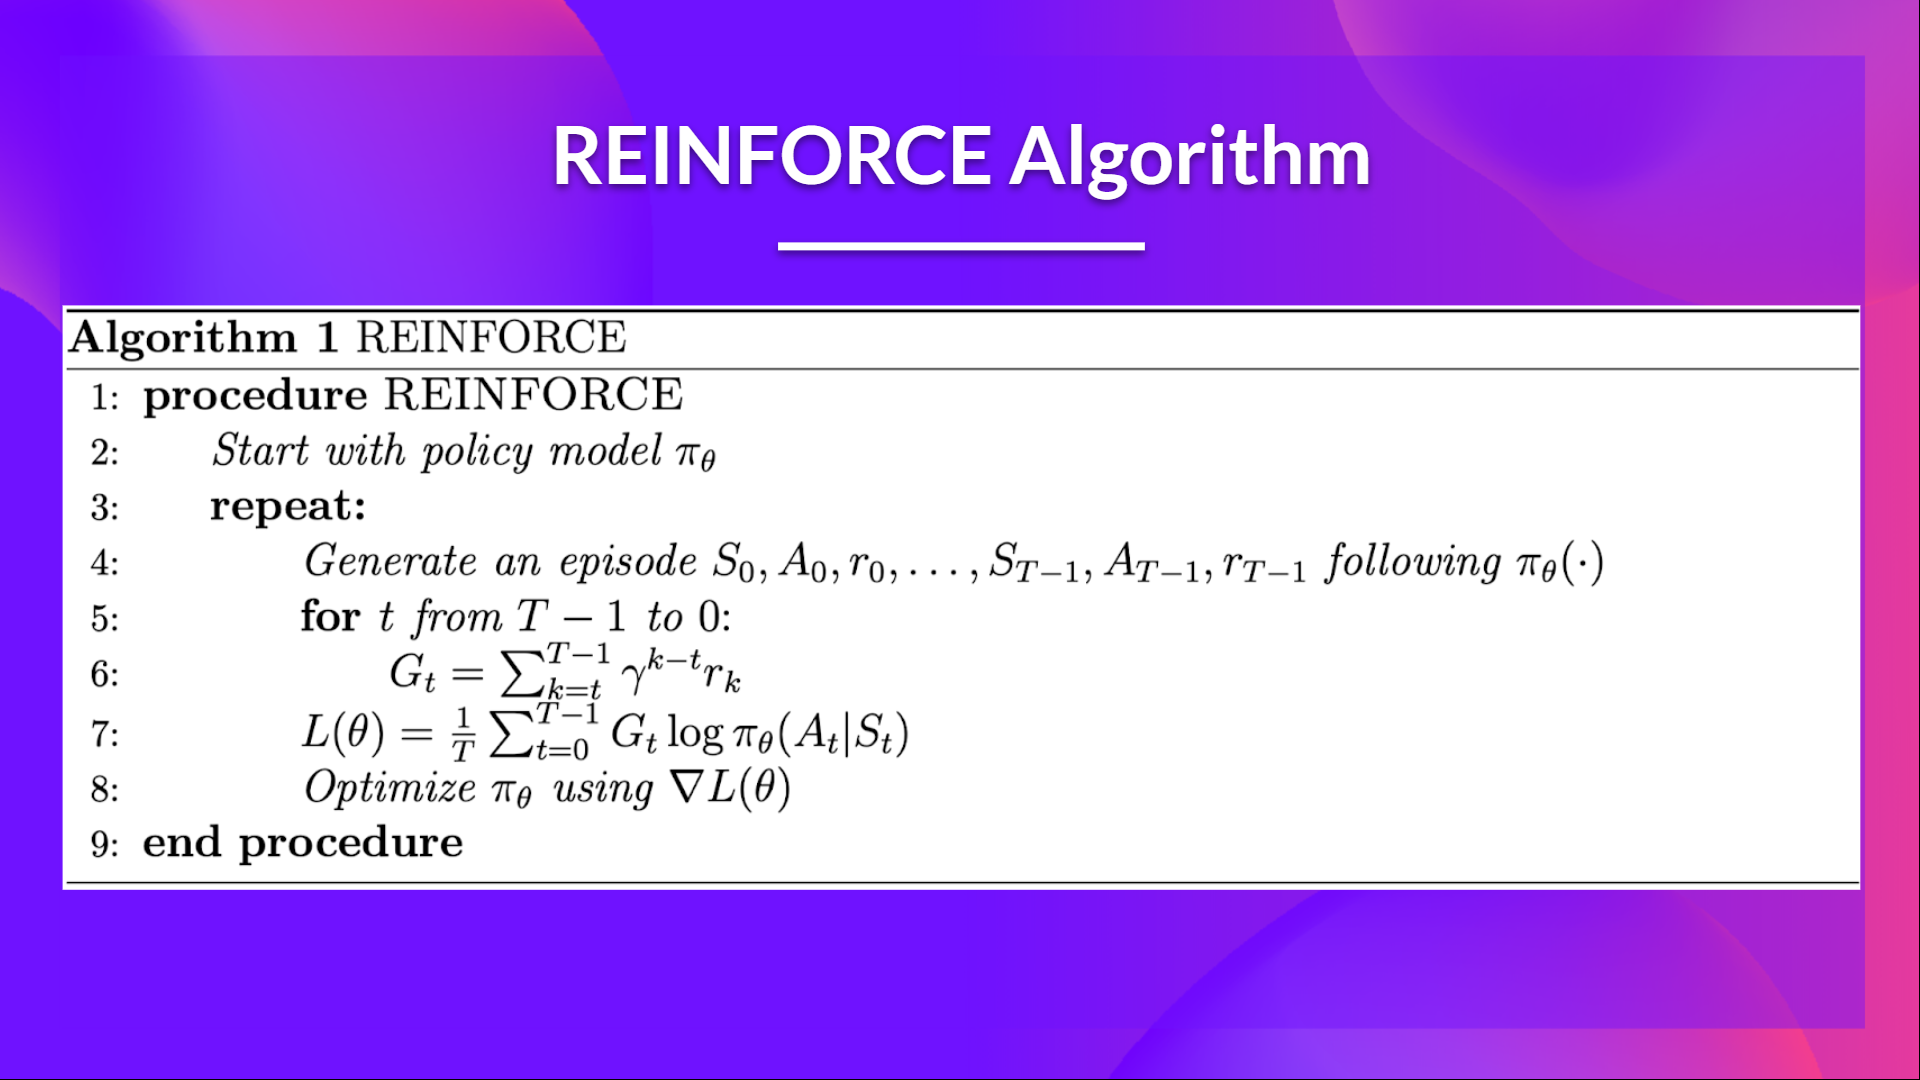

In [8]:

def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        # state = env.reset()
        state, _ = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # state, reward, done, _ = env.step(action)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 
        # Compute the discounted returns at each timestep,
        # as 
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity 
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...
        
        # Given this formulation, the returns at each timestep t can be computed 
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order 
        # to avoid computing them multiple times)
        
        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...
        
        
        ## Given the above, we calculate the returns at timestep t as: 
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed 
        ## if we were to do it from first to last.
        
        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )    
            
        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is 
        # added to the standard deviation of the returns to avoid numerical instabilities        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Line 8: PyTorch prefers gradient descent 
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

train model

In [9]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 100,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [10]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

4 2 16


In [11]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"], 
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"], 
                   100)

Episode 100	Average Score: 40.07


Evaluate

In [16]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info, _ = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [17]:
evaluate_agent(eval_env, 
               cartpole_hyperparameters["max_t"], 
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

/home/alexander/Documents/Programming/Guidelines/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(73.9, 28.724379888867922)

### Example from PyTorch examples

In [15]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [18]:
# parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
#                     help='discount factor (default: 0.99)')
# parser.add_argument('--seed', type=int, default=543, metavar='N',
#                     help='random seed (default: 543)')
# parser.add_argument('--render', action='store_true',
#                     help='render the environment')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='interval between training status logs (default: 10)')
# args = parser.parse_args()

gamma = 0.99
seed = 543
env = gym.make('CartPole-v1')
env.reset()
torch.manual_seed(seed)

In [19]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


In [20]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [23]:

running_reward = 10
for i_episode in count(1):
    # state, _ = env.reset()
    state = env.reset()
    ep_reward = 0
    for t in range(1, 1000):  # Don't infinite loop while learning
        action = select_action(state)
        # state, reward, done, _, _ = env.step(action)
        state, reward, done, _ = env.step(action)
        # env.render()
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            break

    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    finish_episode()
    if i_episode % 10 == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                i_episode, ep_reward, running_reward))
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                "the last episode runs to {} time steps!".format(running_reward, t))
        break

Episode 100	Last reward: 20.00	Average reward: 10.50
Episode 110	Last reward: 12.00	Average reward: 14.31
Episode 120	Last reward: 24.00	Average reward: 17.82
Episode 130	Last reward: 18.00	Average reward: 18.99
Episode 140	Last reward: 35.00	Average reward: 23.29
Episode 150	Last reward: 42.00	Average reward: 25.33
Episode 160	Last reward: 72.00	Average reward: 36.69
Episode 170	Last reward: 50.00	Average reward: 35.67
Episode 180	Last reward: 68.00	Average reward: 37.95
Episode 190	Last reward: 190.00	Average reward: 56.07
Episode 200	Last reward: 31.00	Average reward: 56.82
Episode 210	Last reward: 36.00	Average reward: 58.05
Episode 220	Last reward: 133.00	Average reward: 77.80
Episode 230	Last reward: 83.00	Average reward: 75.72
Episode 240	Last reward: 167.00	Average reward: 103.74
Episode 250	Last reward: 161.00	Average reward: 103.96
Episode 260	Last reward: 194.00	Average reward: 113.15
Episode 270	Last reward: 265.00	Average reward: 159.18
Episode 280	Last reward: 157.00	Aver

KeyboardInterrupt: 